In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import random

In [21]:
# 1. read data
data = pd.read_csv("./Groceries_dataset.csv")

print("Original rows:", len(data))
print("Unique transactions:", data['Member_number'].nunique())
print("Unique items:", data['itemDescription'].nunique())

Original rows: 38765
Unique transactions: 3898
Unique items: 167


In [22]:
# 2. clean dataset
data = data.drop_duplicates(subset=["Member_number", "itemDescription"])

transactions = data.groupby("Member_number")["itemDescription"].apply(list)
print(f"Total transactions: {len(transactions)}")

os.makedirs("datasets", exist_ok=True)

subset_specs = {
    "D1": {"n_tx": 500, "n_items": 50},
    "D2": {"n_tx": 1000, "n_items": 50},
    "D3": {"n_tx": 3000, "n_items": 50},
    "D4": {"n_tx": 1000, "n_items": 100},
    "D5": {"n_tx": len(transactions), "n_items": data['itemDescription'].nunique()},
}

Total transactions: 3898


In [23]:
# 3. generate and save the datasets
for name, spec in subset_specs.items():
    # 随机选交易
    sampled_tx = transactions.sample(n=min(spec["n_tx"], len(transactions)), random_state=42)
    subset_df = data[data["Member_number"].isin(sampled_tx.index)]

    # 控制商品种类
    unique_items = subset_df["itemDescription"].unique().tolist()
    if len(unique_items) > spec["n_items"]:
        selected_items = random.sample(unique_items, spec["n_items"])
        subset_df = subset_df[subset_df["itemDescription"].isin(selected_items)]

    # 保存
    out_path = f"datasets/{name}.csv"
    subset_df.to_csv(out_path, index=False)
    print(f"{name} -> transactions: {subset_df['Member_number'].nunique()}, "
          f"items: {subset_df['itemDescription'].nunique()} saved to {out_path}")

print("All the datasets have been saved!")

D1 -> transactions: 434, items: 50 saved to datasets/D1.csv
D2 -> transactions: 915, items: 50 saved to datasets/D2.csv
D3 -> transactions: 2748, items: 50 saved to datasets/D3.csv
D4 -> transactions: 992, items: 100 saved to datasets/D4.csv
D5 -> transactions: 3898, items: 167 saved to datasets/D5.csv
All the datasets have been saved!


In [24]:
# 4. Load all datasets, run Apriori algorithm and measure execution time
datasets = ["D1", "D2", "D3", "D4", "D5"]
base_path = "datasets"

results = []

for name in datasets:
    path = os.path.join(base_path, f"{name}.csv")
    print(f"\n🔹 Processing {name} from {path}")

    # Read the dataset
    df = pd.read_csv(path)

    # Convert to list of lists (transactions)
    transactions = df.groupby("Member_number")["itemDescription"].apply(list).tolist()

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    start_time = time.time()
    frequent_items = apriori(df_encoded, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_items, metric="confidence", min_threshold=0.5)
    elapsed_time = time.time() - start_time

    print(f"{name}: {len(frequent_items)} frequent itemsets, "
          f"{len(rules)} rules, time = {elapsed_time:.3f} s")

    results.append({
        "Dataset": name,
        "Transactions": len(transactions),
        "Items": len(df_encoded.columns),
        "Apriori_Time(s)": elapsed_time
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("Summary of Apriori Results: ")
print(results_df)



🔹 Processing D1 from datasets/D1.csv
D1: 101 frequent itemsets, 5 rules, time = 0.003 s

🔹 Processing D2 from datasets/D2.csv
D2: 201 frequent itemsets, 58 rules, time = 0.004 s

🔹 Processing D3 from datasets/D3.csv
D3: 204 frequent itemsets, 65 rules, time = 0.008 s

🔹 Processing D4 from datasets/D4.csv
D4: 1282 frequent itemsets, 671 rules, time = 0.028 s

🔹 Processing D5 from datasets/D5.csv
D5: 3016 frequent itemsets, 1117 rules, time = 0.536 s
Summary of Apriori Results: 
  Dataset  Transactions  Items  Apriori_Time(s)
0      D1           434     50         0.002513
1      D2           915     50         0.003868
2      D3          2748     50         0.007631
3      D4           992    100         0.028080
4      D5          3898    167         0.535520


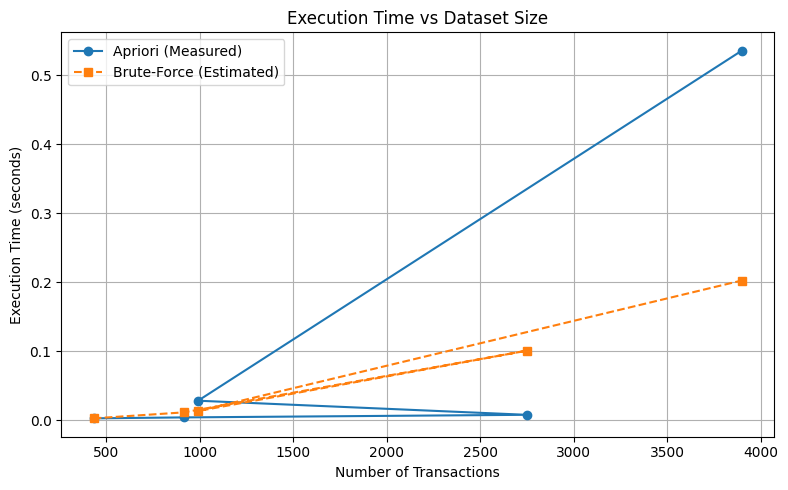

Experiment completed. Plot saved as 'apriori_vs_bruteforce.png'.


In [25]:
# 5. Estimate brute-force time (for comparison) and plot
k = results_df.loc[0, "Transactions"]
t = results_df.loc[0, "Apriori_Time(s)"]
C = t / (k**2 + k)

results_df["BruteForce_Est(s)"] = results_df["Transactions"].apply(
    lambda n: C * (n**2 + n)
)

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(results_df["Transactions"], results_df["Apriori_Time(s)"],
         marker='o', label="Apriori (Measured)")
plt.plot(results_df["Transactions"], results_df["BruteForce_Est(s)"],
         marker='s', linestyle='--', label="Brute-Force (Estimated)")
plt.title("Execution Time vs Dataset Size")
plt.xlabel("Number of Transactions")
plt.ylabel("Execution Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/apriori_vs_bruteforce.png", dpi=300)
plt.show()

print("Experiment completed. Plot saved as 'apriori_vs_bruteforce.png'.")